# CS210 - Term Project
- Beyza Balota
- 31232


- I tried to get some self-awareness with this project.  I decide to use the step count, sleep, and menstrual cycle data from my Apple Health account. I wanted to know if my sleeping patterns or level of activity affected my cycle. I was unable to identify any significant correlations between them. However, because my data set is so small I intend to conduct additional research after gathering years' worth of data.

# Step 1: Data Cleaning
- My health data included many other data that I wont even need like heart rate, energy burned, walking speed, etc.
- So, I started with cleaning them and extracting the data I need which are: step count, sleep count and period data.
- Below code extracts the data and saves the data into .csv files into my computer as new files.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
import xml.etree.ElementTree as ET
import csv
from datetime import datetime

# Load and parse the XML file
tree = ET.parse('/Users/beyzabalota/Desktop/cs210Project/apple_health_export/export.xml')
root = tree.getroot()

# Function to parse and format the date
def parse_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S %z")

# Lists to store cleaned data
sleep_data = []
step_data = []
#menstrual_data = []

# Iterate through records in the XML file
for record in root.findall('Record'):
    record_type = record.get('type')
    if record_type == 'HKCategoryTypeIdentifierSleepAnalysis' and record.get('value') == 'HKCategoryValueSleepAnalysisInBed':
        sleep_data.append({
            'start_date': parse_date(record.get('startDate')),
            'end_date': parse_date(record.get('endDate'))
        })
    elif record_type == 'HKQuantityTypeIdentifierStepCount':
        step_data.append({
            'start_date': parse_date(record.get('startDate')),
            'end_date': parse_date(record.get('endDate')),
            'steps': int(record.get('value'))
        })
    #elif record_type == 'HKCategoryTypeIdentifierMenstrualFlow': # Check the correct type
        #menstrual_data.append({
            #'start_date': parse_date(record.get('startDate')),
            #'end_date': parse_date(record.get('endDate'))
        #})

# Save the cleaned data to CSV files
with open('sleep_data.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['start_date', 'end_date'])
    writer.writeheader()
    writer.writerows(sleep_data)

with open('step_data.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['start_date', 'end_date', 'steps'])
    writer.writeheader()
    writer.writerows(step_data)

#with open('menstrual_data.csv', 'w', newline='') as file:
    #writer = csv.DictWriter(file, fieldnames=['start_date', 'end_date'])
    #writer.writeheader()
    #writer.writerows(menstrual_data)

print("Data cleaning complete. Files saved as sleep_data.csv, step_data.csv, and menstrual_data.csv")



Data cleaning complete. Files saved as sleep_data.csv, step_data.csv, and menstrual_data.csv


# Step 2: Reading and Displaying

- Reading the .csv files that cleaned above and displaying average sleep and step count per day for monthly basis.
- The total steps and total sleep hours columns shows the average daily count of that month


In [3]:
import pandas as pd

# Function to calculate total sleep time in hours
def total_sleep_time(row):
    return (row['end_date'] - row['start_date']).total_seconds() / 3600

# Read the sleep data
sleep_df = pd.read_csv('sleep_data.csv')
sleep_df['start_date'] = pd.to_datetime(sleep_df['start_date']).dt.tz_localize(None)  # Convert to timezone-naive
sleep_df['end_date'] = pd.to_datetime(sleep_df['end_date']).dt.tz_localize(None)      # Convert to timezone-naive
sleep_df['total_sleep_hours'] = sleep_df.apply(total_sleep_time, axis=1)

# Aggregate sleep data by month
sleep_df.set_index('start_date', inplace=True)
monthly_sleep = sleep_df.resample('M')['total_sleep_hours'].sum()

# Read the step data
step_df = pd.read_csv('step_data.csv')
step_df['start_date'] = pd.to_datetime(step_df['start_date']).dt.tz_localize(None)  # Convert to timezone-naive

# Aggregate step data by month
step_df.set_index('start_date', inplace=True)
monthly_steps = step_df.resample('M')['steps'].sum()

# Combine monthly sleep, step, and menstrual day data into a single DataFrame
monthly_summary = pd.DataFrame({
    'Total Sleep Hours': (monthly_sleep / 30).round(2),
    'Total Steps': (monthly_steps / 30).round(2)
}).fillna(0)

# Modify the 'start_date' column to display only the year and month
monthly_summary.index = monthly_summary.index.strftime('%Y-%m')


# Load the menstrual data from the CSV file
menstrual_data_df = pd.read_csv('/Users/beyzabalota/Desktop/beyza_balota_CS210_Project/menstrual_data.csv')

# Assuming your menstrual data has a 'start_date' column that matches the index of the monthly_summary
menstrual_data_df['start_date'] = pd.to_datetime(menstrual_data_df['start_date']).dt.strftime('%Y-%m')
# Merge the menstrual data into the existing DataFrame

monthly_summary = monthly_summary.merge(menstrual_data_df[['start_date', 'cycle']], on='start_date', how='left')
# Display the updated DataFrame with the new 'cycle' column

# Rename 'start_date' column to 'date'
monthly_summary.rename(columns={'start_date': 'date'}, inplace=True)

# Display the DataFrame to confirm the change
display(monthly_summary)




date  Total Sleep Hours  Total Steps  cycle
0   2019-05               0.00      2010.57    NaN
1   2019-06               0.00      3843.20    NaN
2   2019-07               0.00     14306.17    NaN
3   2019-08               0.00      7398.90    NaN
4   2019-09               0.20      3205.73    NaN
5   2019-10               0.00      3959.90    NaN
6   2019-11               0.00      4072.43    NaN
7   2019-12               0.00      3987.07    NaN
8   2020-01               0.00      7432.93    NaN
9   2020-02               0.00      3490.17    NaN
10  2020-03               0.00      2340.63   25.0
11  2020-04               0.00      1675.27   22.0
12  2020-05               1.21      1441.80   24.0
13  2020-06               2.35      1545.37   27.0
14  2020-07               0.96      3085.37   48.0
15  2020-08               2.41      3441.63    0.0
16  2020-09               0.59      2556.43   23.0
17  2020-10               0.00      2685.90   22.0
18  2020-11               2.46      2091.03   24.0
19  2020-12               5.96      1169.27   29.0
20  2021-01               4.91      3565.33   24.0
21  2021-02               3.11      2560.83   29.0
22  2021-03               4.94      3052.27   25.0
23  2021-04               5.13      1291.57   27.0
24  2021-05               5.21      4152.20   28.0
25  2021-06               6.86      3430.23   27.0
26  2021-07               4.54      3964.13   29.0
27  2021-08               6.24      2571.67   30.0
28  2021-09               6.11      3921.50   29.0
29  2021-10               5.67      5271.30   25.0
30  2021-11               6.40      5641.00   20.0
31  2021-12               7.42      3524.47   15.0
32  2022-01               7.66      2482.60   29.0
33  2022-02               7.68      4649.53   29.0
34  2022-03               7.88      5104.07   23.0
35  2022-04               6.32      4267.30   27.0
36  2022-05               6.39      4215.40   31.0
37  2022-06               6.91      5158.90   28.0
38  2022-07               8.21      8190.47   25.0
39  2022-08               7.40      3783.67   26.0
40  2022-09               7.38      3212.60   28.0
41  2022-10               7.17      4625.17   30.0
42  2022-11               6.80      5366.43   27.0
43  2022-12               7.52      8954.67   22.0
44  2023-01               7.32      7321.97   30.0
45  2023-02               6.66      4089.53   24.0
46  2023-03               7.92      7710.23   29.0
47  2023-04               8.46      4743.63   27.0
48  2023-05               8.26      4896.87   26.0
49  2023-06               7.65      5495.00   28.0
50  2023-07               8.80      4604.30   28.0
51  2023-08               8.32      6486.27   29.0
52  2023-09               7.43      4394.73   30.0
53  2023-10               6.60      6368.87   29.0
54  2023-11               7.55      4766.17   29.0
55  2023-12               8.18      5271.27   26.0
56  2024-01               3.39      1850.00   23.0

# Step 3: Understanding and Preprocessing

- Displaying the info about the dataframe
- Filling the Nan values for my cycle and 0 values for the sleep data
- Here, I realized that I have wrong data for sleep calculations in few months. My average sleep was coming less than 2 hours per day.
- So I decided to fill these values with the mean of my sleep, which I believe would be best for the errored data after my researches.
- Unfortunately, this filling method have also some bad impact such as less variance.

In [4]:


# Displaying information about the DataFrame
display(monthly_summary.info())

# Fill NaN values with the most common value for 'cycle' column
most_common_value = monthly_summary['cycle'].mode()[0] if not monthly_summary['cycle'].mode().empty else 0
monthly_summary['cycle'].fillna(most_common_value, inplace=True)

# Convert 'cycle' column to integer
monthly_summary['cycle'] = monthly_summary['cycle'].astype(int)

# Calculate the mean of the 'Total Sleep Hours' for values greater than 2
valid_sleep_data_mean = monthly_summary[monthly_summary['Total Sleep Hours'] > 2]['Total Sleep Hours'].mean()

# Replace values less than or equal to 2 with this mean and round to two decimal places
monthly_summary.loc[monthly_summary['Total Sleep Hours'] <= 2, 'Total Sleep Hours'] = valid_sleep_data_mean
monthly_summary['Total Sleep Hours'] = monthly_summary['Total Sleep Hours'].round(2)

# Now your monthly_summary DataFrame will have the 'Total Sleep Hours' corrected
# And you can print the DataFrame without the 'Daily Average Sleep Hours' column
display(monthly_summary.head()
        )




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               57 non-null     object 
 1   Total Sleep Hours  57 non-null     float64
 2   Total Steps        57 non-null     float64
 3   cycle              47 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.9+ KB


None

date  Total Sleep Hours  Total Steps  cycle
0  2019-05               6.43      2010.57     29
1  2019-06               6.43      3843.20     29
2  2019-07               6.43     14306.17     29
3  2019-08               6.43      7398.90     29
4  2019-09               6.43      3205.73     29

- since my data is all numeric, I decided not to do encoding, instead created new columns as year and month allow models to
- detect patterns based on time, such as seasonal trends or year-over-year changes.

In [5]:
# Convert 'date' to datetime
monthly_summary['date'] = pd.to_datetime(monthly_summary['date'])

# Extract year and month as separate features
monthly_summary['year'] = monthly_summary['date'].dt.year
monthly_summary['month'] = monthly_summary['date'].dt.month

# Now 'year' and 'month' are numeric features that can be used in a model
display(monthly_summary.head())


date  Total Sleep Hours  Total Steps  cycle  year  month
0 2019-05-01               6.43      2010.57     29  2019      5
1 2019-06-01               6.43      3843.20     29  2019      6
2 2019-07-01               6.43     14306.17     29  2019      7
3 2019-08-01               6.43      7398.90     29  2019      8
4 2019-09-01               6.43      3205.73     29  2019      9

# Step 4; Set X & Y, split and shuffle the data
- This part is preparing the data for machine learning by splitting and shuffling

In [6]:
from sklearn.model_selection import train_test_split

# Assuming 'monthly_summary' is your DataFrame and 'health_metrics' is the column you want to predict
# Replace 'health_metrics' with the actual name of your dependent variable column
# Also assuming that 'monthly_summary' already has the 'year' and 'month' columns created and 'date' column dropped

# Shuffle the dataset
monthly_summary = monthly_summary.sample(frac=1).reset_index(drop=True)

# Separate X (features) and y (target)
X = monthly_summary.drop('cycle', axis=1)  # Replace 'health_metrics' with the actual target column name
y = monthly_summary['cycle']  # Replace 'health_metrics' with the actual target column name

# Split into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the first 5 rows of X_train (independent variables) and y_train (dependent variable) for training data
print("Training Data (X_train and y_train):")
display(X_train.head())
display(y_train.head())

# Display the first 5 rows of X_test (independent variables) and y_test (dependent variable) for testing data
print("Testing Data (X_test and y_test):")
display(X_test.head())
display(y_test.head())


Training Data (X_train and y_train):


date  Total Sleep Hours  Total Steps  year  month
43 2020-02-01               6.43      3490.17  2020      2
26 2024-01-01               3.39      1850.00  2024      1
8  2021-10-01               5.67      5271.30  2021     10
17 2023-04-01               8.46      4743.63  2023      4
6  2022-11-01               6.80      5366.43  2022     11

43    29
26    23
8     25
17    27
6     27
Name: cycle, dtype: int64

Testing Data (X_test and y_test):


date  Total Sleep Hours  Total Steps  year  month
0  2023-08-01               8.32      6486.27  2023      8
5  2021-07-01               4.54      3964.13  2021      7
30 2020-03-01               6.43      2340.63  2020      3
13 2019-08-01               6.43      7398.90  2019      8
34 2019-05-01               6.43      2010.57  2019      5

0     29
5     29
30    25
13    29
34    29
Name: cycle, dtype: int64

# Step 5: Visualization of the Data Frame

Heathmap:

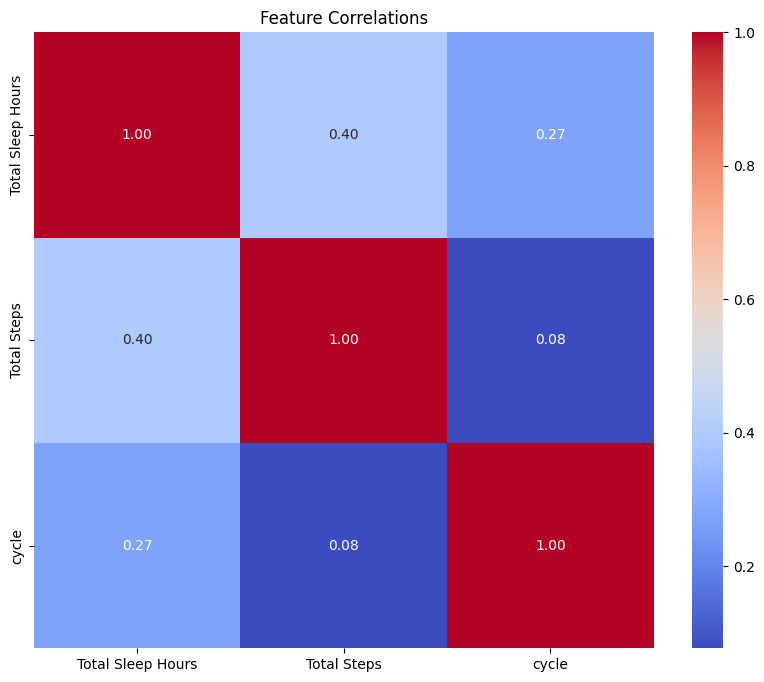

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns but exclude 'year' and 'month'
numeric_columns = monthly_summary.select_dtypes(include=[np.number]).columns
columns_to_include = numeric_columns.drop(['year', 'month'])  # Drop 'year' and 'month' columns

# Calculate correlations for selected columns only
correlation_matrix = monthly_summary[columns_to_include].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlations")
plt.show()



Scatterplot:

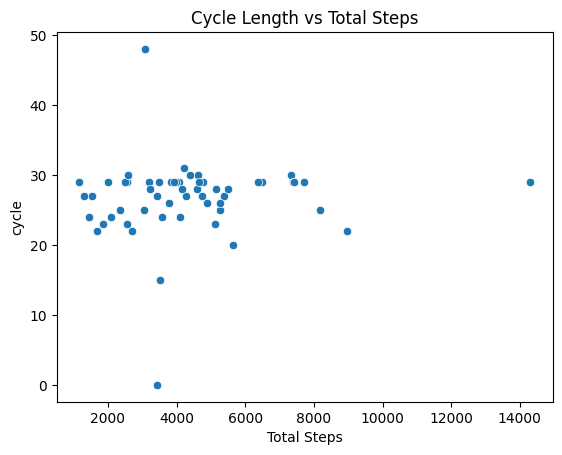

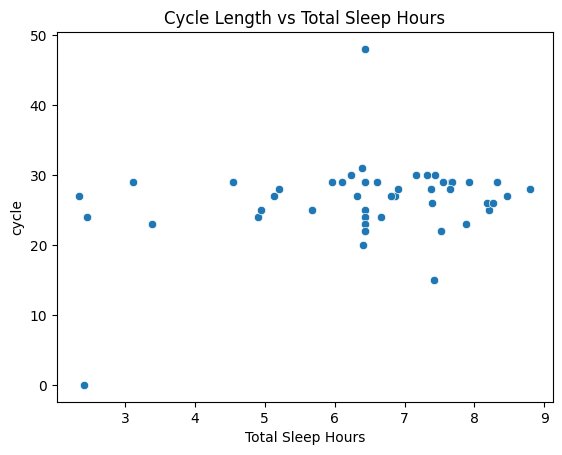

In [8]:
sns.scatterplot(data=monthly_summary, x='Total Steps', y='cycle')
plt.title('Cycle Length vs Total Steps')
plt.show()

sns.scatterplot(data=monthly_summary, x='Total Sleep Hours', y='cycle')
plt.title('Cycle Length vs Total Sleep Hours')
plt.show()


Pairplot:

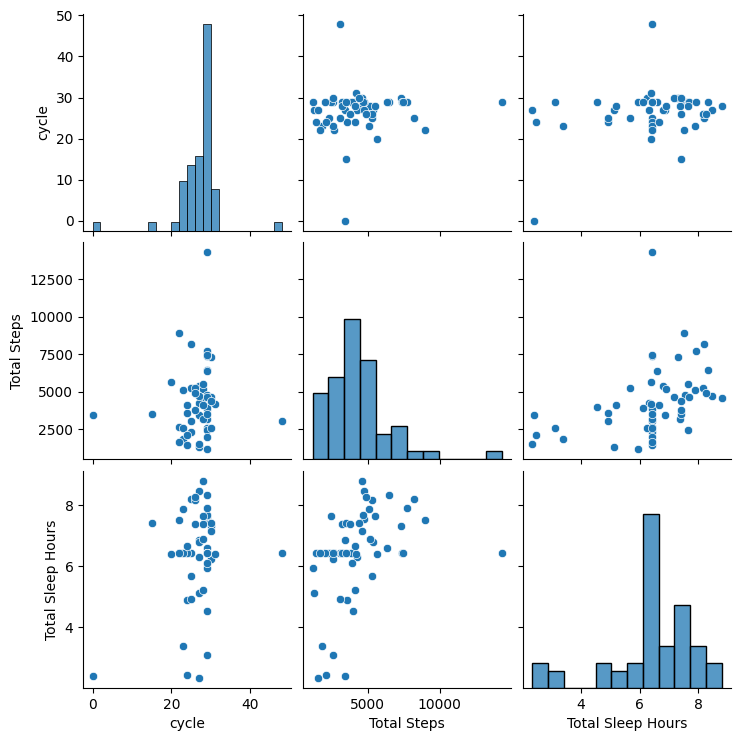

In [9]:
# It's better to use a subset of variables or it can be overwhelming
sns.pairplot(monthly_summary[['cycle', 'Total Steps', 'Total Sleep Hours']])
plt.show()


# Step 6: Tune Hyperparameter
- Used regression, classifer was inconclusive. My data includes continous numerical values.
- this part is for prediciton


In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X = monthly_summary[['Total Sleep Hours', 'Total Steps']]
y = monthly_summary['cycle']  

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters and their possible values to tune for regression
param_grid = {
    'max_depth': [3, 5, 10, None],  # None means the nodes are expanded until all leaves are pure or contain less than min_samples_split samples.
    'min_samples_split': [2, 5, 10]
}

# Create the DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)

# Create the GridSearchCV object with cross-validation for regression
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error')  # Use regression scoring

# Fit the GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best estimator (model)
best_regressor = grid_search.best_estimator_

# Evaluate the model with the best hyperparameters on your test data
y_pred = best_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Best Hyperparameters:", best_params)
print("Test MSE with Best Hyperparameters:", mse)
print("Test R2 with Best Hyperparameters:", r2)


Best Hyperparameters: {'max_depth': 3, 'min_samples_split': 10}
Test MSE with Best Hyperparameters: 4.104665205112959
Test R2 with Best Hyperparameters: -0.7033769150901044


# Step 7: Machine Learning

- Re-training the tree with the hyperparameters.

In [11]:


from sklearn.tree import DecisionTreeRegressor

# Create a DecisionTreeRegressor with the chosen hyperparameters
dt_regressor_optimized = DecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42  # You can set the random state for reproducibility
)

# Fit the model on the training data
dt_regressor_optimized.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)

- Printing the trained tree

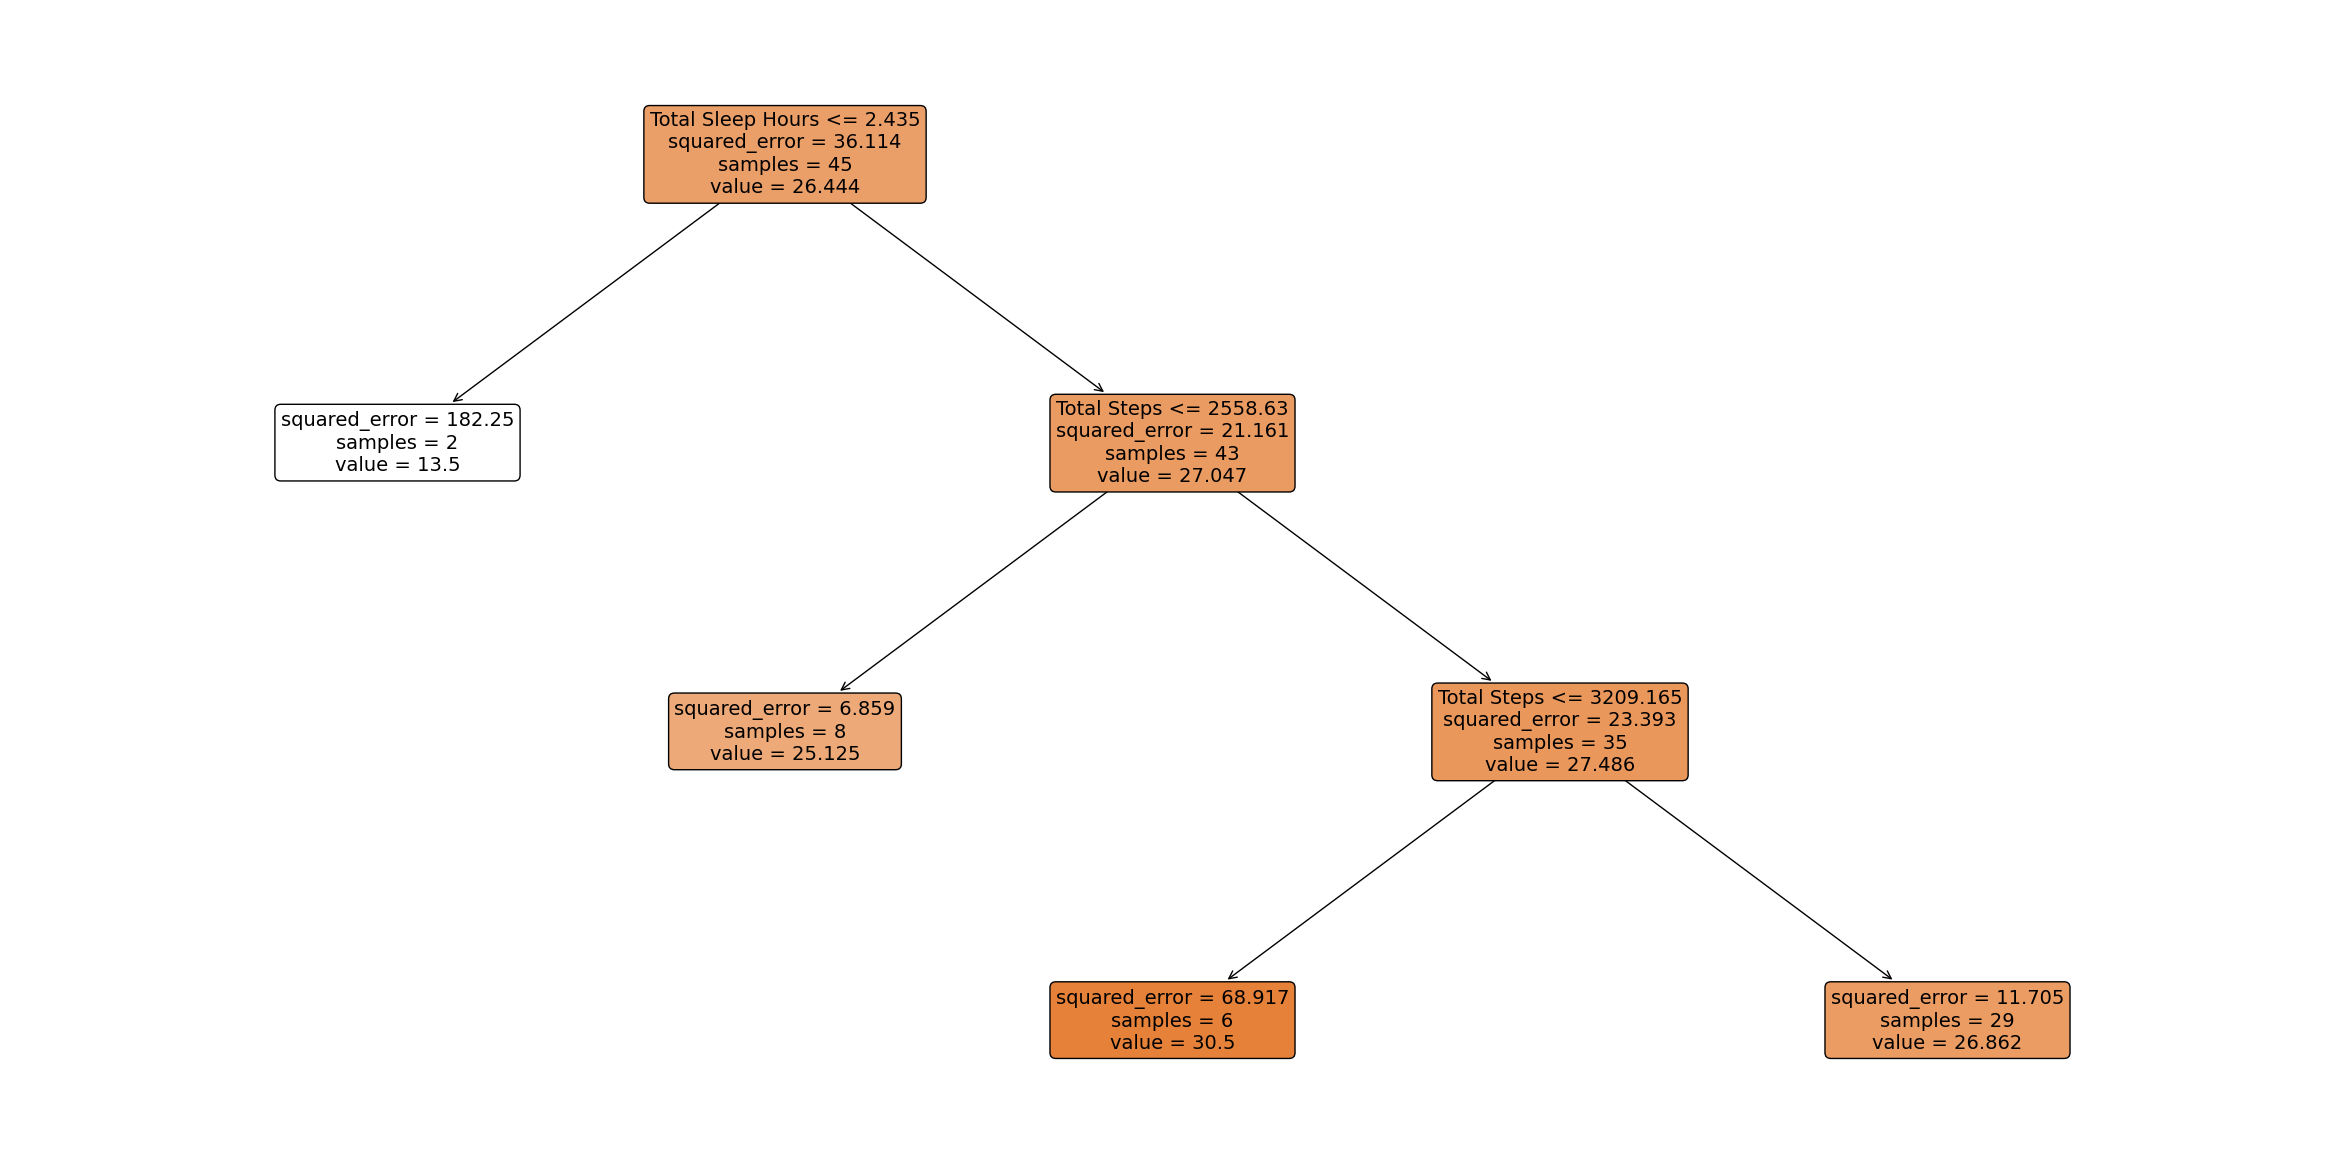

In [12]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the decision tree
plt.figure(figsize=(30,15))  # Set the figure size (width, height) as needed
feature_names = X_train.columns  # Feature names from your dataset

plot_tree(dt_regressor_optimized, 
          feature_names=feature_names, 
          filled=True, 
          rounded=True, 
          fontsize=14)
plt.show()



# Step 8: Prediction

In [13]:
# Assuming you have new data in a DataFrame called 'new_data'
new_data = pd.DataFrame({'Total Sleep Hours': [7.5, 6.0, 8.0],
                         'Total Steps': [6000, 4500, 7500]})

# Make predictions on the new data
predictions = best_regressor.predict(new_data)

# Print the predicted values
print("Predicted 'cycle' values for the new data:")
print(predictions)


Predicted 'cycle' values for the new data:
[26.86206897 26.86206897 26.86206897]
